# REMARKS

In this **alternative version 1**:
-  I remove **predicted_reward** because in this problem, the reward is **always 1**

-  I change the feed_dict in the sess.run(updateModel) command to:
        {
            previous_state: epXandAction
            true_observation: np.vstack([epx[1: ], observation])
            true_done: epd
        }
        
    Notice how it is different from the **main version** of this notebook, especially in **previous_state, true_done, true_observation**:

        {
            previous_state: epXandAction[: -1],
            true_observation: epx[1: ],
            true_reward: epr[1: ],
            true_done: epd[1: ]
        }
        
Some explanation:
-    In the main version, the **very last** observation (obtained when **done==True**) is **ignored**. It can be appended into **true_observation** so that the whole epXandAction can be used to update model.

-    The logic of the code is: At state epx[i], we pick an action and then obtain state exp[i + 1] with reward epr[i] and done signal epd[i]. Therefore, I believe my feed_dict approach in this alternative version is *more* correct. However, the **mean_reward** received here is not as high as in the main version. The reason behind this phenomenom is still unclear to me.

# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [4]:
# Hyperparameters
H = 8 # number of Hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # Discount factor for reward
decay_rate = 0.99 # Decay factor for RMSProp leaky sum of grad^2
resume = False # Resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# Nodel initialization
D = 4 # Input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()

observations = tf.placeholder(tf.float32, [None, 4], name = "input_x")

W1 = tf.get_variable(
    "W1",
    shape = [4, H],
    initializer = tf.contrib.layers.xavier_initializer()
)
layer1 = tf.nn.relu(tf.matmul(observations, W1))

W2 = tf.get_variable(
    "W2",
    shape=[H, 1],
    initializer = tf.contrib.layers.xavier_initializer()
)

score = tf.matmul(layer1, W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()

input_y = tf.placeholder(tf.float32, [None, 1], name = "input_y")
advantages = tf.placeholder(tf.float32, name = "reward_signal")

adam = tf.train.AdamOptimizer(learning_rate = learning_rate)
W1Grad = tf.placeholder(tf.float32, name = "batch_grad1")
W2Grad = tf.placeholder(tf.float32, name = "batch_grad2")
batchGrad = [W1Grad, W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################

logLikelihood = tf.log(
    (1 - input_y) * probability
    + input_y * (1 - probability)
)

loss = -tf.reduce_mean(logLikelihood * advantages)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss, tvars)
updateGrads = adam.apply_gradients(zip(batchGrad, tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # Model layer size

# input_data = tf.placeholder(tf.float32, [None, 5])  # Redundant ???

with tf.variable_scope("rnnlm"):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None, 5], name = "previous_state")

W1M = tf.get_variable(
    "W1M",
    shape = [5, mH],
    initializer = tf.contrib.layers.xavier_initializer()
)
B1M = tf.Variable(tf.zeros([mH]), name = "B1M")

layer1M = tf.nn.relu(tf.matmul(previous_state, W1M) + B1M)

W2M = tf.get_variable(
    "W2M",
    shape = [mH, mH],
    initializer = tf.contrib.layers.xavier_initializer()
)
B2M = tf.Variable(tf.zeros([mH]), name = "B2M")

layer2M = tf.nn.relu(tf.matmul(layer1M, W2M) + B2M)

wO = tf.get_variable(
    "wO",
    shape = [mH, 4],
    initializer = tf.contrib.layers.xavier_initializer()
)

wD = tf.get_variable(
    "wD",
    shape = [mH, 1],
    initializer = tf.contrib.layers.xavier_initializer()
)

bO = tf.Variable(tf.zeros([4]), name = "bO")
bD = tf.Variable(tf.ones([1]), name="bD")

predicted_observation = tf.matmul(layer2M, wO, name = "predicted_observation") + bO
predicted_done = tf.sigmoid(tf.matmul(layer2M, wD, name = "predicted_done") + bD)

true_observation = tf.placeholder(tf.float32, [None, 4], name = "true_observation")
true_done = tf.placeholder(tf.float32, [None, 1], name = "true_done")

predicted_state = tf.concat([predicted_observation, predicted_done], 1)

observation_loss = tf.square(true_observation - predicted_observation)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1 - predicted_done, 1 - true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate = learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer



def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################

    result = np.zeros_like(r, dtype = np.float32)

    cumm = 0.0        
    for i in xrange(result.shape[0] - 1, -1, -1):
        cumm = cumm * gamma + r[i, 0]
        result[i, 0] = cumm        
    
    return result        
    
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    
    
# This function uses our model to produce a new state when given a previous state and action
# xs: Set of states
def stepModel(sess, xs, action):
    # Just feed the last state in the set xs
    toFeed = np.reshape(
        np.hstack([xs[-1][0], np.array(action)]),
        [1, 5]
    )
    
    myPredict = sess.run([predicted_state], feed_dict = {previous_state: toFeed})
    
    reward = 1
    
    observation = myPredict[0][:, 0: 4]
    observation[:, 0] = np.clip(observation[:, 0], -2.4, 2.4)
    observation[:, 2] = np.clip(observation[:, 2], -0.4, 0.4)
    
    doneP = np.clip(myPredict[0][:, 4], 0, 1)
        
    if doneP > 0.1 or len(xs) >= 300:
        done = True
    else:
        done = False
        
    return observation, reward, done

## Training the Policy and Model

In [8]:
xs, drs, ys, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1

init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model

trainThePolicy = False # Whether to train the policy

switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    
    sess.run(init)
    
    observation = env.reset()
    x = observation
    
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum / batch_size > 150 and drawFromModel == False) or rendering == True: 
            env.render()
            rendering = True
            
        x = np.reshape(observation, [1, 4])

        tfprob = sess.run(probability, feed_dict = {observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # Record various intermediates (needed later for backprop)
        xs.append(x)
        
        y = 1 if action == 0 else 0    # "Fake" label
        ys.append(y)
        
        # Step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess, xs, action)
            
        reward_sum += reward
        
        ds.append(done * 1)
        
        # Record reward (has to be done after we call step() to get reward for previous action)
        drs.append(reward) 

        if done:
            episode_number += 1
            
            if drawFromModel == False: 
                real_episodes += 1

            # Stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            
            xs, drs, ys, ds = [], [], [], [] # Reset array memory
            
            if trainTheModel == True:                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                
                state_nextsAll = np.hstack([epx, epr, epd])
                
                # Note: action & y is ALWAYS opposite
                epXandAction = np.hstack([epx, 1 - epy])
                
                pState, _ = sess.run([predicted_state, updateModel], feed_dict = {
                    previous_state: epXandAction,
                    true_observation: np.vstack([epx[1: ], observation]),
                    true_done: epd
                })
                
                pState = np.hstack([
                    pState[:, 0: 4],
                    np.ones([pState.shape[0], 1]),
                    pState[:, 4].reshape([-1, 1])
                ])
                
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                
                discounted_epr = discount_rewards(epr)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                
                tGrad = sess.run(newGrads, feed_dict = {
                    observations: epx,
                    input_y: epy,
                    advantages: discounted_epr
                })
                
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                    
                for ix, grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number:
                switch_point = episode_number
                
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    
                    sess.run(updateGrads, feed_dict = {
                        W1Grad: gradBuffer[0],
                        W2Grad: gradBuffer[1]
                    })
                    
                    gradBuffer = resetGradBuffer(gradBuffer)
                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else (running_reward * 0.99 + reward_sum * 0.01)
                
                if drawFromModel == False:
                    print("World Perf: Episode %d. Reward %f. action: %f. mean reward %f." % (
                        real_episodes,
                        reward_sum / real_bs,
                        action,
                        running_reward / real_bs
                    ))
                    
                    if reward_sum / batch_size > 200:
                        break
                        
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################                 
                    
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    
                    trainThePolicy = not trainThePolicy                    
                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1, 0.1, [4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4. Reward 25.333333. action: 0.000000. mean reward 25.333333.
World Perf: Episode 7. Reward 30.666667. action: 0.000000. mean reward 25.386667.
World Perf: Episode 10. Reward 18.333333. action: 0.000000. mean reward 25.316133.
World Perf: Episode 13. Reward 20.666667. action: 0.000000. mean reward 25.269639.
World Perf: Episode 16. Reward 22.333333. action: 1.000000. mean reward 25.240276.
World Perf: Episode 19. Reward 18.666667. action: 0.000000. mean reward 25.174540.
World Perf: Episode 22. Reward 21.666667. action: 0.000000. mean reward 25.139461.
World Perf: Episode 25. Reward 11.666667. action: 0.000000. mean reward 25.004733.
World Perf: Episode 28. Reward 26.666667. action: 0.000000. mean reward 25.021352.
World Perf: Episode 31. Reward 24.666667. action: 1.000000. mean reward 25.017805.
World Perf: Episode 34. Reward 15.333333. action: 1.000000. mean reward 24.920961.
World Perf: Episode 37. Reward 12.333333. action: 0.000000. mean reward 24.795084.
World 

World Perf: Episode 310. Reward 33.333333. action: 0.000000. mean reward 33.798975.
World Perf: Episode 313. Reward 35.000000. action: 1.000000. mean reward 33.631475.
World Perf: Episode 316. Reward 35.333333. action: 1.000000. mean reward 33.384842.
World Perf: Episode 319. Reward 37.000000. action: 1.000000. mean reward 33.252184.
World Perf: Episode 322. Reward 18.333333. action: 1.000000. mean reward 32.951999.
World Perf: Episode 325. Reward 32.333333. action: 0.000000. mean reward 32.721887.
World Perf: Episode 328. Reward 23.333333. action: 0.000000. mean reward 32.548255.
World Perf: Episode 331. Reward 40.666667. action: 0.000000. mean reward 32.422711.
World Perf: Episode 334. Reward 25.000000. action: 0.000000. mean reward 32.265099.
World Perf: Episode 337. Reward 22.000000. action: 0.000000. mean reward 33.027724.
World Perf: Episode 340. Reward 37.000000. action: 0.000000. mean reward 35.099972.
World Perf: Episode 343. Reward 38.333333. action: 0.000000. mean reward 34.

World Perf: Episode 604. Reward 72.666667. action: 0.000000. mean reward 36.558066.
World Perf: Episode 607. Reward 52.000000. action: 0.000000. mean reward 39.320561.
World Perf: Episode 610. Reward 53.333333. action: 0.000000. mean reward 42.041415.
World Perf: Episode 613. Reward 85.666667. action: 1.000000. mean reward 45.031457.
World Perf: Episode 616. Reward 71.333333. action: 0.000000. mean reward 45.000465.
World Perf: Episode 619. Reward 43.666667. action: 1.000000. mean reward 44.630722.
World Perf: Episode 622. Reward 44.666667. action: 0.000000. mean reward 44.242037.
World Perf: Episode 625. Reward 57.000000. action: 0.000000. mean reward 44.080121.
World Perf: Episode 628. Reward 38.333333. action: 0.000000. mean reward 43.668760.
World Perf: Episode 631. Reward 43.000000. action: 0.000000. mean reward 43.407951.
World Perf: Episode 634. Reward 54.000000. action: 1.000000. mean reward 46.054133.
World Perf: Episode 637. Reward 29.000000. action: 1.000000. mean reward 45.

World Perf: Episode 913. Reward 81.000000. action: 0.000000. mean reward 51.068079.
World Perf: Episode 916. Reward 47.333333. action: 1.000000. mean reward 50.558158.
World Perf: Episode 919. Reward 65.333333. action: 1.000000. mean reward 50.294484.
World Perf: Episode 922. Reward 25.000000. action: 1.000000. mean reward 49.606324.
World Perf: Episode 925. Reward 60.333333. action: 1.000000. mean reward 49.324791.
World Perf: Episode 928. Reward 126.666667. action: 1.000000. mean reward 49.758394.
World Perf: Episode 931. Reward 71.666667. action: 1.000000. mean reward 49.554169.
World Perf: Episode 934. Reward 41.000000. action: 1.000000. mean reward 49.284941.
World Perf: Episode 937. Reward 44.333333. action: 1.000000. mean reward 51.717504.
World Perf: Episode 940. Reward 26.666667. action: 1.000000. mean reward 53.096692.
World Perf: Episode 943. Reward 63.666667. action: 1.000000. mean reward 52.752635.
World Perf: Episode 946. Reward 39.000000. action: 1.000000. mean reward 52

World Perf: Episode 1207. Reward 106.000000. action: 1.000000. mean reward 91.804023.
World Perf: Episode 1210. Reward 116.666667. action: 0.000000. mean reward 93.575890.
World Perf: Episode 1213. Reward 107.666667. action: 1.000000. mean reward 95.760396.
World Perf: Episode 1216. Reward 91.000000. action: 0.000000. mean reward 95.094764.
World Perf: Episode 1219. Reward 93.333333. action: 1.000000. mean reward 94.363412.
World Perf: Episode 1222. Reward 110.333333. action: 1.000000. mean reward 93.892513.
World Perf: Episode 1225. Reward 92.333333. action: 1.000000. mean reward 95.917385.
World Perf: Episode 1228. Reward 107.666667. action: 1.000000. mean reward 98.055296.
World Perf: Episode 1231. Reward 181.000000. action: 1.000000. mean reward 100.883996.
World Perf: Episode 1234. Reward 131.000000. action: 1.000000. mean reward 103.156404.
World Perf: Episode 1237. Reward 107.000000. action: 1.000000. mean reward 104.321892.
World Perf: Episode 1240. Reward 115.000000. action: 1

World Perf: Episode 1492. Reward 155.000000. action: 0.000000. mean reward 130.165386.
World Perf: Episode 1495. Reward 139.333333. action: 1.000000. mean reward 129.113628.
World Perf: Episode 1498. Reward 159.000000. action: 0.000000. mean reward 131.104267.
World Perf: Episode 1501. Reward 95.333333. action: 1.000000. mean reward 132.200825.
World Perf: Episode 1504. Reward 141.000000. action: 0.000000. mean reward 131.187929.
World Perf: Episode 1507. Reward 106.333333. action: 1.000000. mean reward 129.802322.
World Perf: Episode 1510. Reward 160.333333. action: 0.000000. mean reward 128.987590.
World Perf: Episode 1513. Reward 166.000000. action: 0.000000. mean reward 128.305137.
World Perf: Episode 1516. Reward 164.333333. action: 0.000000. mean reward 129.332298.
World Perf: Episode 1519. Reward 156.000000. action: 0.000000. mean reward 128.513285.
World Perf: Episode 1522. Reward 187.000000. action: 1.000000. mean reward 129.908171.
World Perf: Episode 1525. Reward 153.333333.

World Perf: Episode 1777. Reward 183.000000. action: 1.000000. mean reward 154.392694.
World Perf: Episode 1780. Reward 199.000000. action: 1.000000. mean reward 153.554480.
World Perf: Episode 1783. Reward 184.666667. action: 1.000000. mean reward 152.939412.
World Perf: Episode 1786. Reward 182.666667. action: 0.000000. mean reward 152.293485.
World Perf: Episode 1789. Reward 167.666667. action: 0.000000. mean reward 152.975611.
World Perf: Episode 1792. Reward 196.333333. action: 1.000000. mean reward 154.864730.
World Perf: Episode 1795. Reward 200.000000. action: 0.000000. mean reward 156.752922.
World Perf: Episode 1798. Reward 188.000000. action: 1.000000. mean reward 158.483538.
World Perf: Episode 1801. Reward 187.666667. action: 0.000000. mean reward 160.176383.
World Perf: Episode 1804. Reward 156.000000. action: 1.000000. mean reward 160.723573.
World Perf: Episode 1807. Reward 173.666667. action: 0.000000. mean reward 159.463140.
World Perf: Episode 1810. Reward 172.000000

World Perf: Episode 2062. Reward 200.000000. action: 1.000000. mean reward 167.667051.
World Perf: Episode 2065. Reward 192.333333. action: 0.000000. mean reward 169.223810.
World Perf: Episode 2068. Reward 200.000000. action: 1.000000. mean reward 168.371056.
World Perf: Episode 2071. Reward 200.000000. action: 0.000000. mean reward 169.082972.
World Perf: Episode 2074. Reward 200.000000. action: 0.000000. mean reward 167.853521.
World Perf: Episode 2077. Reward 200.000000. action: 0.000000. mean reward 169.483236.
World Perf: Episode 2080. Reward 200.000000. action: 1.000000. mean reward 170.176319.
World Perf: Episode 2083. Reward 200.000000. action: 0.000000. mean reward 170.839111.
World Perf: Episode 2086. Reward 200.000000. action: 1.000000. mean reward 170.993712.
World Perf: Episode 2089. Reward 200.000000. action: 1.000000. mean reward 170.646938.
World Perf: Episode 2092. Reward 185.333333. action: 0.000000. mean reward 169.398097.
World Perf: Episode 2095. Reward 183.666667

World Perf: Episode 2347. Reward 177.666667. action: 0.000000. mean reward 175.272251.
World Perf: Episode 2350. Reward 163.333333. action: 0.000000. mean reward 176.387666.
World Perf: Episode 2353. Reward 178.000000. action: 0.000000. mean reward 174.723552.
World Perf: Episode 2356. Reward 181.000000. action: 0.000000. mean reward 176.026553.
World Perf: Episode 2359. Reward 183.000000. action: 0.000000. mean reward 176.716424.
World Perf: Episode 2362. Reward 156.000000. action: 0.000000. mean reward 175.126068.
World Perf: Episode 2365. Reward 185.000000. action: 0.000000. mean reward 176.461059.
World Perf: Episode 2368. Reward 184.333333. action: 1.000000. mean reward 177.762817.
World Perf: Episode 2371. Reward 165.000000. action: 1.000000. mean reward 178.845337.
World Perf: Episode 2374. Reward 178.000000. action: 0.000000. mean reward 177.729615.
World Perf: Episode 2377. Reward 200.000000. action: 1.000000. mean reward 179.162796.
World Perf: Episode 2380. Reward 178.333333

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

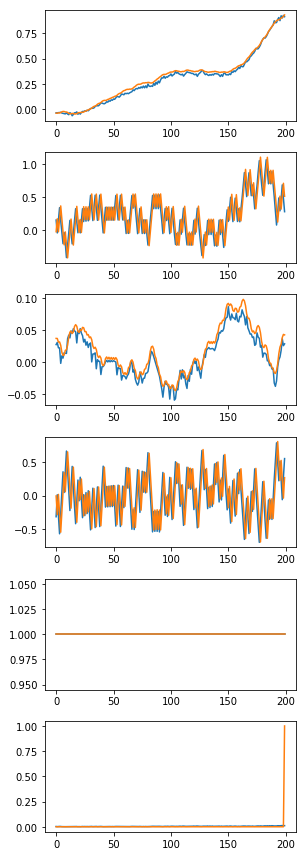

In [9]:
plt.figure(figsize = (8, 12))

for i in range(6):
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(pState[:, i])
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(state_nextsAll[:, i])
    
plt.tight_layout()